# Custom DFT for hi-res low-freqs spectrograms

## install, import, init, upload

In [0]:
%%capture
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import files
from glob import glob
from PIL import Image
import os
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import zipfile
# import sys
# plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.figsize'] = [30, 30]
# plt.rcParams['figure.figsize'] = [12, 12]

In [0]:
def track_to_chunks(track, chunk_n=100000):
    # make track divisible by chunk (track_n % chunk_n == 0)
    track = np.pad(
        track,
        pad_width=(0, chunk_n - len(track) % chunk_n),
        mode='constant', 
        constant_values=0
    )
    track_chunks = track.reshape((len(track) // chunk_n, chunk_n))
    return track_chunks

In [0]:
def save_spectrogram_to_png(spectrogram, filename='spectrogram'):
    with open(f'{filename}.png', 'wb') as file:
        plt.imsave(file, spectrogram, cmap='viridis', origin='lower')

    
# import matplotlib.cm as cm


# spectrogram_norm = np.flipud(spectrogram) * 1.0/spectrogram.max() # 0..1
# # print(spectrogram_norm.shape)
# # plt.imshow(spectrogram_norm)
# # print(spectrogram.dtype)
# # np.uint8(cm.viridis(spectrogram_norm)*255).max()
# im = Image.fromarray(np.uint8(cm.viridis(spectrogram_norm)*255))
# im.save('spectrogram_PIL.png', optimize=True, compress_level=9)
# files.download('spectrogram_PIL.png')

In [0]:
def zip_pngs(zipname='spectrogram.zip'):
    '''
    наверное нужно также тайминги 
    и всю метаинформацию 
    в .txt и в .zip-ку добавлять
    '''
    pngs = glob('*.png')
    with zipfile.ZipFile(zipname, 'w') as z:        
        for i, png in enumerate(pngs):
            print(f'png {i+1}/{len(pngs)}\t{os.stat(png).st_size / 1000000} MB')
            z.write(png, compress_type=zipfile.ZIP_DEFLATED)
            
    zipsize = os.stat(zipname).st_size / 1000000
    print(f'{zipname}\t{zipsize} MB')

In [0]:
def zip_jpgs(zipname='spectrogram-jpg.zip', jpg_width=400):
    '''
    small jpg thumbnails
    '''
    pngs = glob('*.png')
   
    with zipfile.ZipFile(zipname, 'w') as z:        
        for i, png in enumerate(pngs):
            im = Image.open(png)
            im.convert('RGB')
            
            width_percent = jpg_width / im.size[0]
            jpg_height = int(im.size[1] * width_percent)
            
            size = (jpg_width, jpg_height)
            im.thumbnail(size)
            jpg = os.path.splitext(png)[0] + '.jpg'
            im.save(jpg, quality=95)
            print(f'jpg {i+1}/{len(pngs)}\t{os.stat(jpg).st_size / 1000000} MB')
            z.write(jpg, compress_type=zipfile.ZIP_DEFLATED)
            os.remove(jpg)
            
    zipsize = os.stat(zipname).st_size / 1000000
    print(f'{zipname}\t{zipsize} MB')

In [0]:
def compute_spectrogram(chunk, nperseg=11025, noverlap=11000, f_n=11025, rate=44100):
    step = nperseg - noverlap

    chunk = track
    shape = chunk.shape[:-1] + ((chunk.shape[-1] - noverlap) // step, nperseg)
    strides = chunk.strides[:-1] + (step * chunk.strides[-1], chunk.strides[-1])
    chunk_rolled = cp.array(np.lib.stride_tricks.as_strided(chunk, shape=shape, strides=strides))


    t_chunk = np.linspace(0, nperseg / rate, nperseg, dtype=track.dtype)
    # f = np.logspace(np.log10(30), np.log10(nperseg//2), f_n, dtype=track.dtype) # second arg: nperseg//2 (Nyquist limit)
    f = np.geomspace(30, nperseg//2, f_n) # second arg: nperseg//2 (Nyquist limit)

    T_chunk, F_chunk = np.meshgrid(t_chunk, f)
    E = cp.array(np.exp(-2j * np.pi * F_chunk * T_chunk), dtype=np.complex64) # complex64: Complex number, represented by two 32-bit floats (real and imaginary components)

    corr = cp.dot(chunk_rolled, E.T)
    magnitude = cp.abs(corr)

    spectrogram = cp.asnumpy(magnitude.T)
    return spectrogram

In [55]:
uploaded = files.upload()
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving todi.wav to todi.wav
User uploaded file "todi.wav" with length 705644 bytes


In [0]:
!ls

In [9]:
from scipy.io import wavfile
rate, track = wavfile.read('16s.wav') # now supports only mono .wav files
wav_dtype = track.dtype

wav_max = np.iinfo(wav_dtype).max
wav_min = np.iinfo(wav_dtype).min

track = track.astype(np.float32)
track = (track - wav_min) * 2 / (wav_max - wav_min) -1 # normalise -1..1

print(track.dtype)
# track = x[:20000]
# left_channel  = x[:, 0]
# right_channel = x[:, 1]
# track = left_channel
# average left and right channels to mono signal (reaaly bad, don't do this)
# track = (left_channel + right_channel) / 2 
N = len(track)
t = np.linspace(0, N/rate, N, dtype=track.dtype)
print(t.dtype)
# plt.grid()
# plt.plot(t, track, 'k-', linewidth=0.1)
track_chunks = track_to_chunks(track)
print(track_chunks.shape)

float32
float32
(31, 100000)


## process

In [16]:
for i, chunk in enumerate(track_chunks):
    print(f'chunk {i + 1}/{len(track_chunks)}', end='\t')
    print('computing spectrogram..', end='\t')
    chunk_spectrogram = compute_spectrogram(chunk, nperseg=5000, noverlap=4500, rate=rate)
    
    print('saving png..', end='\t')
    save_spectrogram_to_png(chunk_spectrogram, filename=str(i))
    print('done')

chunk 1/31	computing spectrogram..	saving png..
chunk 2/31	computing spectrogram..	saving png..
chunk 3/31	computing spectrogram..	saving png..
chunk 4/31	computing spectrogram..	saving png..
chunk 5/31	computing spectrogram..	saving png..
chunk 6/31	computing spectrogram..	saving png..
chunk 7/31	computing spectrogram..	saving png..
chunk 8/31	computing spectrogram..	saving png..
chunk 9/31	computing spectrogram..	saving png..
chunk 10/31	computing spectrogram..	saving png..
chunk 11/31	computing spectrogram..	saving png..
chunk 12/31	computing spectrogram..	saving png..
chunk 13/31	computing spectrogram..	saving png..
chunk 14/31	computing spectrogram..	saving png..
chunk 15/31	computing spectrogram..	saving png..
chunk 16/31	computing spectrogram..	saving png..
chunk 17/31	computing spectrogram..	saving png..
chunk 18/31	computing spectrogram..	saving png..
chunk 19/31	computing spectrogram..	saving png..
chunk 20/31	computing spectrogram..	saving png..
chunk 21/31	computing spectro

## zip

## compressed jpeg thumbnails

In [63]:
!ls

0.png	14.png	 18.png  22.png  27.png  3.png	8.png		     todi.wav
10.png	15.png	 19.png  23.png  28.png  4.png	9.png
11.png	16.png	 1.png	 24.png  29.png  5.png	datalab
12.png	16s.wav  20.png  25.png  2.png	 6.png	spectrogram-jpg.zip
13.png	17.png	 21.png  26.png  30.png  7.png	spectrogram.zip


In [62]:
jpeg_zipname = 'spectrogram-jpg.zip'
zip_jpgs(zipname=jpeg_zipname) # 


jpg 1/31	0.065632 MB
jpg 2/31	0.065632 MB
jpg 3/31	0.065632 MB
jpg 4/31	0.065632 MB
jpg 5/31	0.065632 MB
jpg 6/31	0.065632 MB
jpg 7/31	0.065632 MB
jpg 8/31	0.065632 MB
jpg 9/31	0.065632 MB
jpg 10/31	0.065632 MB
jpg 11/31	0.065632 MB
jpg 12/31	0.065632 MB
jpg 13/31	0.065632 MB
jpg 14/31	0.065632 MB
jpg 15/31	0.065632 MB
jpg 16/31	0.065632 MB
jpg 17/31	0.065632 MB
jpg 18/31	0.065632 MB
jpg 19/31	0.065632 MB
jpg 20/31	0.065632 MB
jpg 21/31	0.065632 MB
jpg 22/31	0.065632 MB
jpg 23/31	0.065632 MB
jpg 24/31	0.065632 MB
jpg 25/31	0.065632 MB
jpg 26/31	0.065632 MB
jpg 27/31	0.065632 MB
jpg 28/31	0.065632 MB
jpg 29/31	0.065632 MB
jpg 30/31	0.065632 MB
jpg 31/31	0.065632 MB
spectrogram-jpg.zip	2.020489 MB


MessageError: ignored

In [0]:
files.download(jpeg_zipname)

In [34]:
zip_pngs(zipname='spectrogram.zip')

png 0/31	11.225045 MB
png 1/31	11.225045 MB
png 2/31	11.225045 MB
png 3/31	11.225045 MB
png 4/31	11.225045 MB
png 5/31	11.225045 MB
png 6/31	11.225045 MB
png 7/31	11.225045 MB
png 8/31	11.225045 MB
png 9/31	11.225045 MB
png 10/31	11.225045 MB
png 11/31	11.225045 MB
png 12/31	11.225045 MB
png 13/31	11.225045 MB
png 14/31	11.225045 MB
png 15/31	11.225045 MB
png 16/31	11.225045 MB
png 17/31	11.225045 MB
png 18/31	11.225045 MB
png 19/31	11.225045 MB
png 20/31	11.225045 MB
png 21/31	11.225045 MB
png 22/31	11.225045 MB
png 23/31	11.225045 MB
png 24/31	11.225045 MB
png 25/31	11.225045 MB
png 26/31	11.225045 MB
png 27/31	11.225045 MB
png 28/31	11.225045 MB
png 29/31	11.225045 MB
png 30/31	11.225045 MB
spectrogram.zip	347.814453 MB


## download
короче Colab не дает скачать large files.
- Нужно либо заливать их на google drive
- либо качать маленькими файлами. 
- Либо заливать куда-то еще / на свой сайт / а потом уже оттуда выкачивать.

In [0]:
file_to_download = 'spectrogram.zip'
# files.download(file_to_download)
# Create & upload a file.
uploaded = drive.CreateFile({'title': file_to_download})
uploaded.SetContentFile(file_to_download)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# strided spectrogram

In [0]:
def plot_spectrogram(specgram):
    t_for_spectrogram = np.linspace(0, N/rate, spectrogram.shape[1])
    T, F = np.meshgrid(t_for_spectrogram, f)
    spec_filtered = np.copy(spectrogram)
    plt.pcolormesh(T, F, spec_filtered, cmap='viridis')
    plt.grid(False)
    plt.show()

# Unoptimised spectrogram using `for` loop

In [43]:
from scipy.signal import tukey, gaussian


nperseg  = 11025 // 2
# noverlap = nperseg -1
noverlap = nperseg // 100 * 98

step = nperseg - noverlap
f_N = nperseg // 1
spectrogram = np.empty( ((signal.shape[-1] - noverlap) // step, f_N) , dtype=signal.dtype)
t_chunk = np.linspace(0, nperseg / rate, nperseg, dtype=signal.dtype)
f = np.logspace(np.log10(30), np.log10(nperseg//2), f_N, dtype=signal.dtype) # second arg: nperseg//2 (Nyquist limit)
# f       = np.geomspace(30, nperseg//2, f_N) # second arg: nperseg//2 (Nyquist limit)


T_chunk, F_chunk = np.meshgrid(t_chunk, f)
E = cp.array(np.exp(-2j * np.pi * F_chunk * T_chunk), dtype=np.complex64) # complex64: Complex number, represented by two 32-bit floats (real and imaginary components)


# lines_for_plot_windows = []
# blur_kernel = gaussian(50, std=3)
# blur_kernel = gaussian(50, std=10)
# acoustic_filter = 12200**2 * f**2 / (f**2 + 20.6**2) / (f**2 + 12200**2) # siggigue.github.io/pyfilterbank/splweighting.html


j = 0
for i in range(0, N, step):
    if j % 20 == 0:
        sys.stdout.write('\r')
        sys.stdout.write(f'{j + 1}/{spectrogram.shape[0]}')
        sys.stdout.flush()

    chunk = cp.array(signal[i : i + nperseg])
    
    if E.shape[1] == chunk.shape[0]:
#         print(chunk.shape, np.hanning(nperseg).shape)
#         chunk = chunk * np.hamming(nperseg)
#         chunk = chunk * np.bartlett(nperseg)
#         chunk = chunk * np.blackman(nperseg)
#         chunk = chunk * gaussian(nperseg, std=0.1)
        
#         corr = E @ chunk
    
        corr = cp.dot(E, chunk)
    
        magnitude = np.abs(corr.get())
        
#         magnitude = np.abs(corr)
        
#         lines_for_plot_windows.append(t[i])
#         lines_for_plot_windows.append(t[i + nperseg])
        
        
        
#         magnitude[magnitude < magnitude.max()/4] = 0
        
#         magnitude = magnitude * np.geomspace(1, 10000, f_N) # high freqs saturation
  
          # =====
#         maximas_mask = np.r_[True, magnitude[1:] > magnitude[:-1]] & np.r_[magnitude[:-1] > magnitude[1:], True]
#         sharp_peaks = np.zeros_like(magnitude)
#         sharp_peaks[maximas_mask] = magnitude[maximas_mask]
          # =====
#         
#           threshold = np.max(sharp_peaks) / 10
#         threshold = np.sort(magnitude[maximas_mask])[-2] # take only n peaks
#         sharp_peaks[sharp_peaks < threshold] = 0 # filter out small maximas
#         sharp_peaks[maximas_mask] = 1
  
#         spectrogram[j] = np.correlate(sharp_peaks, blur_kernel, mode='same') * acoustic_filter
#         spectrogram[j] = np.correlate(sharp_peaks, blur_kernel, mode='same') * f
#         spectrogram[j] = np.correlate(sharp_peaks, blur_kernel, mode='same') # <---------- this
        spectrogram[j] = magnitude
#         spectrogram[j] = sharp_peaks
        j += 1
sys.stdout.write('\r')
sys.stdout.write(f'{spectrogram.shape[0]}/{spectrogram.shape[0]}')

1503/1503

(1, 1503)
(1, 1503)
(2205, 1032)


TypeError: ignored

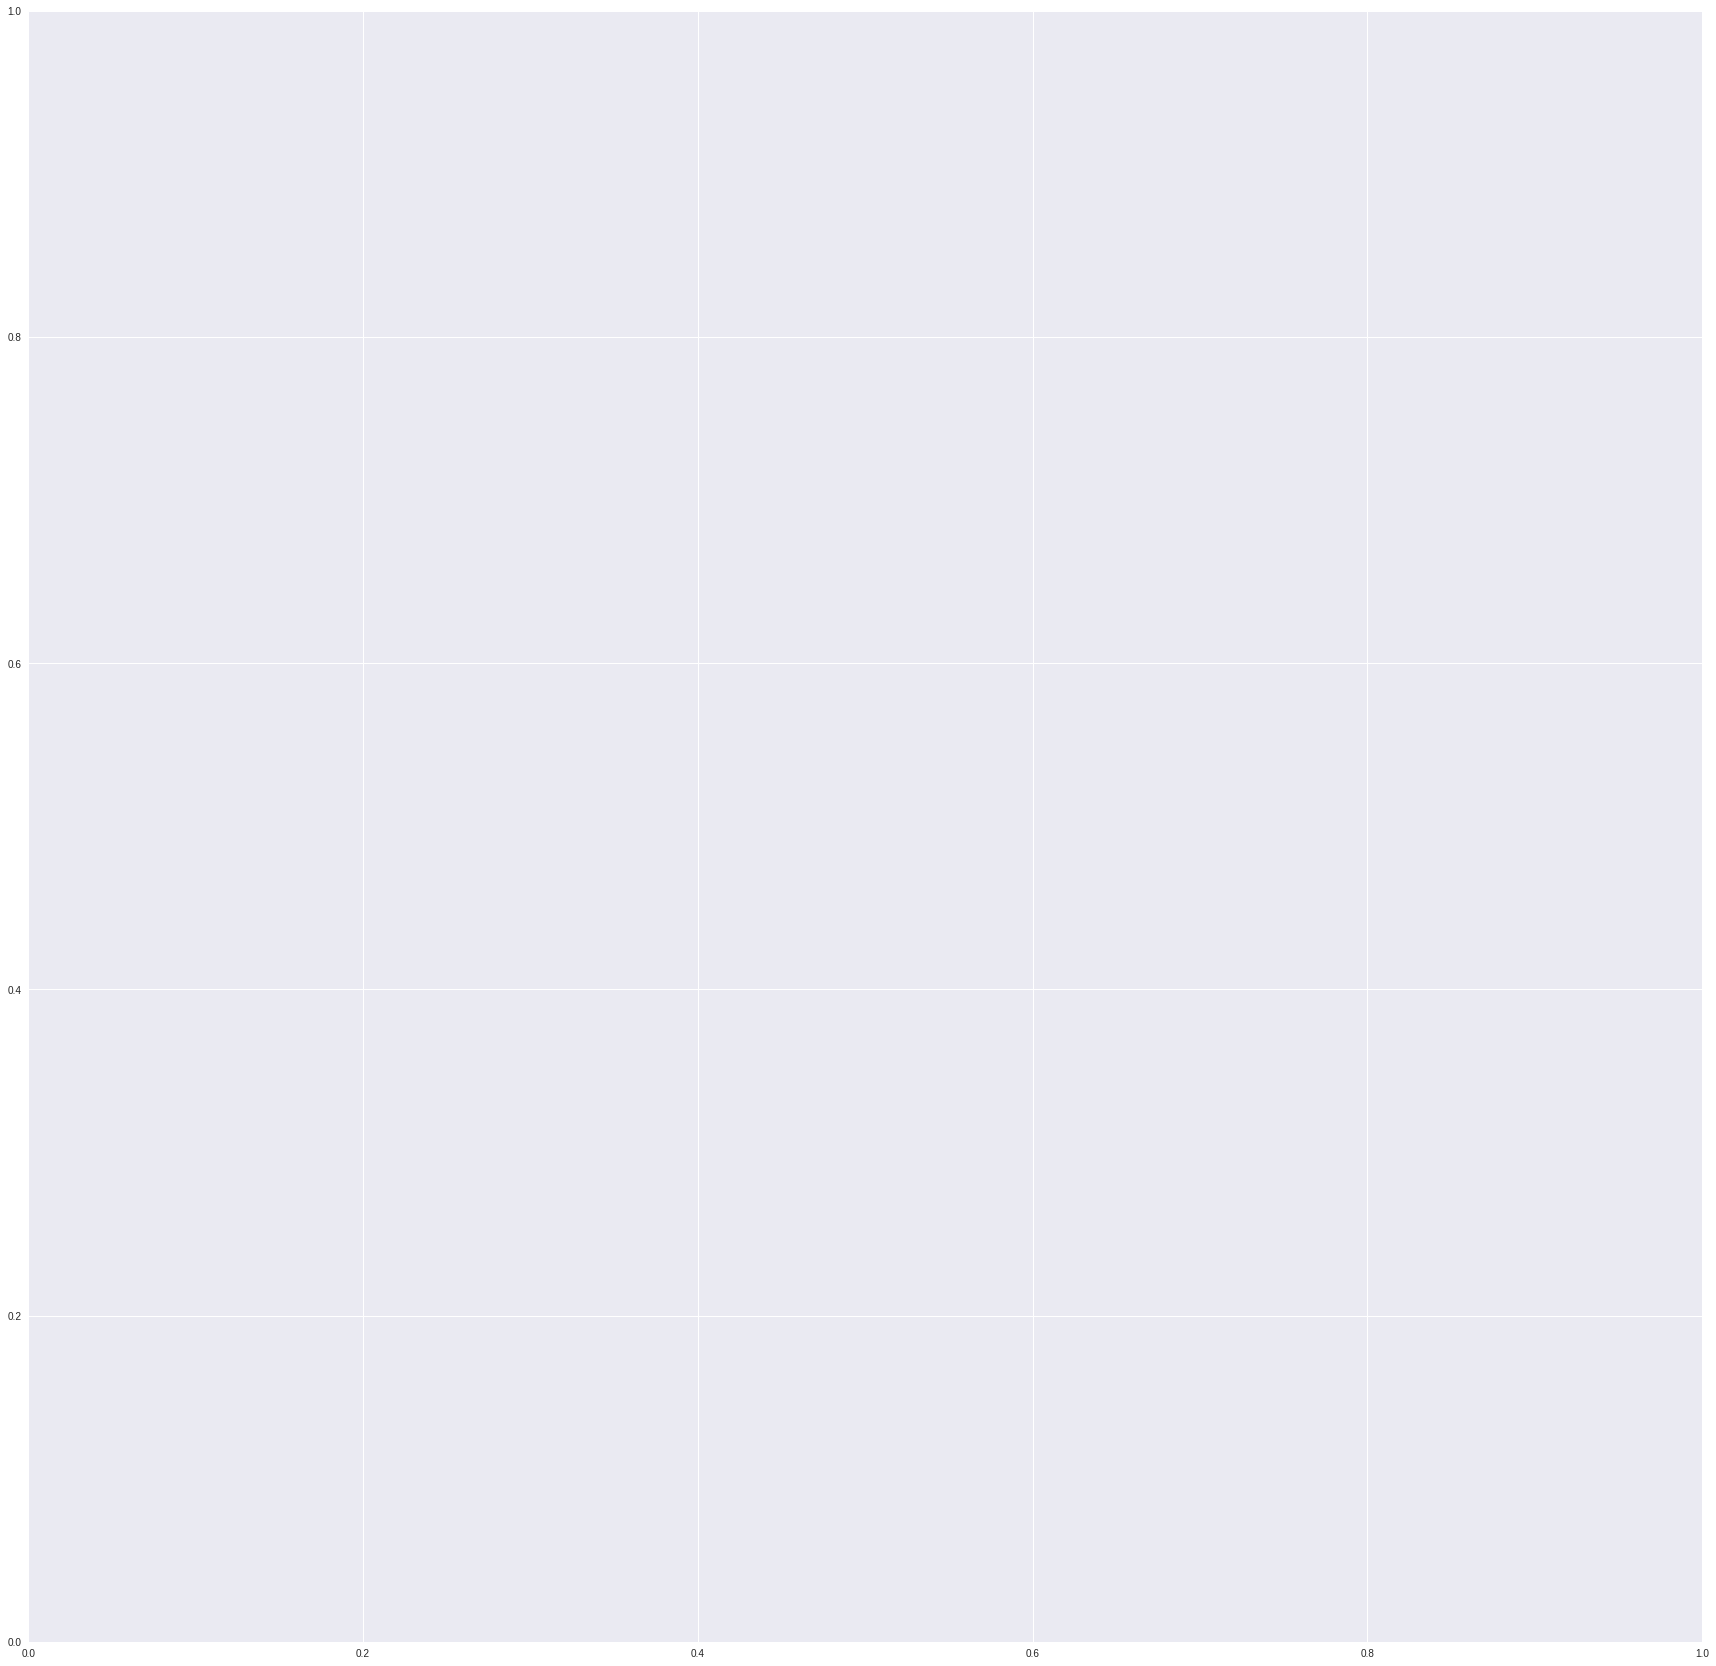

In [55]:
t_for_spectrogram = np.linspace(0, N/rate, j)
T, F = np.meshgrid(t_for_spectrogram, f)


spec_filtered = np.copy(spectrogram.T)
# spec_filtered = np.clip(spectrogram.T, 0, 500000000)
# spec_filtered = np.clip(spectrogram.T, 0, 1000000000)
# spec_filtered = 20 * np.log10(spec_filtered)
# print(T.shape, F.shape, spec_filtered.shape)
# spec_filtered[spec_filtered < 2000000] = 0


plt.pcolormesh(T, F, spec_filtered, cmap='viridis')
# plt.pcolormesh(T, F, spec_filtered, cmap='viridis', vmax=40000000)
# slize_start = 6000
# slize_end = 8000
# plt.pcolormesh(T[:slize], F[:slize], spec_filtered[:slize, :], cmap='viridis', vmax=5000000)
# plt.pcolormesh(T[slize_start:slize_end], F[slize_start:slize_end], spec_filtered[slize_start:slize_end, :], cmap='viridis', vmax=5000000)

# sa = 261.63 # C4 Hz
# semitones_range = np.arange(13)
# freqlines = sa * 2**(semitones_range/12)
# notes = ['Sa', 're', 'Re', 'ga', 'Ga', 'ma', 'Ma', 'Pa', 'dha', 'Dha', 'ni', 'Ni', 'Sa\'']

# for freq, note in zip(freqlines, notes):
#   plt.text(-0.2, freq, note, fontsize=12)

# freqlines = np.array([261, 350, 372, 415, 522])
plt.semilogy()
# plt.hlines(freqlines, xmin=0, xmax=N/rate, linewidth=0.1, color='w', label='Sa')

# plt.vlines(lines_for_plot_windows, ymin=f[0], ymax=f[-1], linewidth=0.1, color='w')

# plt.text(-0.2, 261, 'Sa', fontsize=12)
# plt.text(-0.2, 350, 'ma', fontsize=12)
# plt.text(-0.2, 372, 'Ma', fontsize=12)
# plt.text(-0.2, 415, 'dha', fontsize=12)
# plt.text(-0.2, 522, 'Sa', fontsize=12)

# plt.hlines(f, xmin=0, xmax=400, linewidth=1, color='w')
# plt.axhline(y=261, linewidth=1, color='w')
plt.grid(False)
plt.show()

# etc

In [45]:
spec_filtered[:1000, :].shape

(1000, 1686)

In [0]:
 a = spectrogram[123]

# stackoverflow.com/a/4625132/4204843
# z = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
z = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas

gg = np.zeros(len(a))
gg[z] = a[z]
plt.plot(f, spectrogram[123])
plt.plot(f, gg)
plt.grid(False)

In [62]:
cc = np.array([0, 1, 2, 3, 4, 2, 1, 2, 4, 7 ,8, 7, 1])
nn = len(cc)
zz = np.r_[True, cc[1:] > cc[:-1]] & np.r_[cc[:-1] > cc[1:], True] # maximas
print(zz)
gg = np.zeros(nn)

gg[zz] = cc[zz]
gg
# cc[zz]

[False False False False  True False False False False False  True False
 False]


array([0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 8., 0., 0.])

In [0]:
f = np.linspace(0, N//4, N*2)
T, F = np.meshgrid(t, f)
E = np.exp(-2j * np.pi * F * T)

corr = E @ signal
# magnitude = 20 * np.log10(np.abs(corr))
magnitude = np.abs(corr)

# slic = 100

# plt.plot(f[:slic], magnitude[:slic])
plt.plot(f, magnitude)

# corr.shape
# corr

In [0]:
x = np.arange(8)
x
nperseg  = 3
noverlap = 2
step = nperseg - noverlap

((x.shape[-1] - noverlap) // step, nperseg)
# x.shape
# x.shape[-1] 

(6, 3)

# convolution / correlation with gaussian blur filter

In [0]:
a = spectrogram[72]

# stackoverflow.com/a/4625132/4204843
# z = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
z = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas

gg = np.zeros(len(a))
gg[z] = a[z]
plt.plot(f, a)
plt.plot(f, gg)
plt.grid(False)

(1575,)


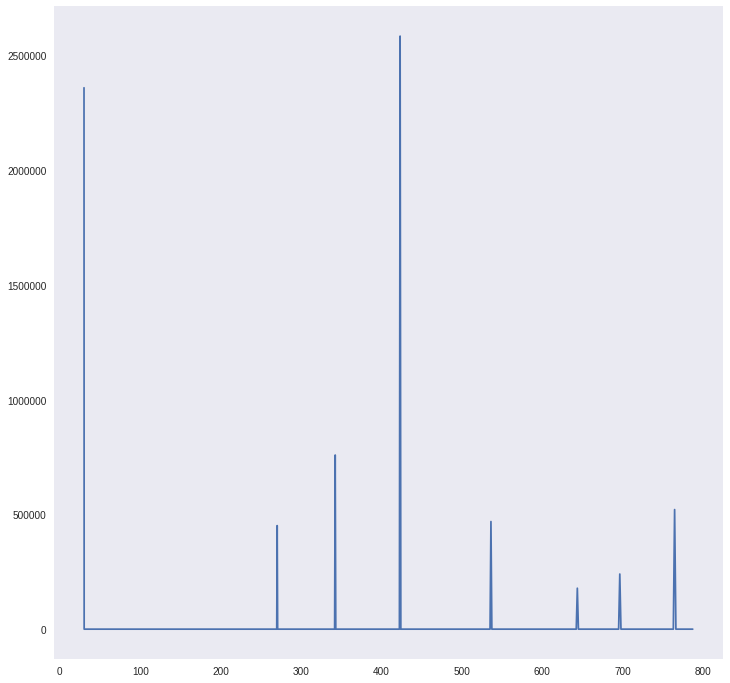

In [11]:
# plt.plot(f, a)
plt.plot(f, gg)
plt.grid(False)
print(gg.shape)

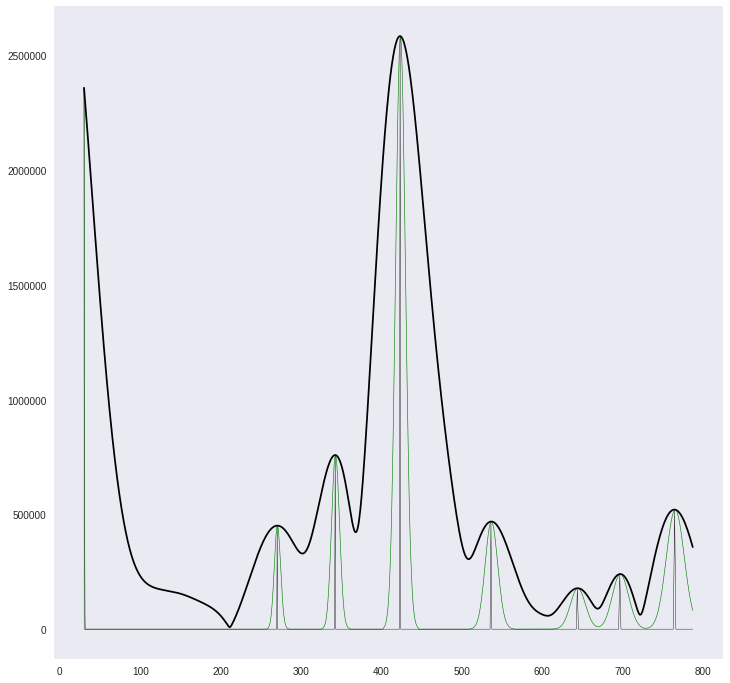

In [58]:
from scipy.signal import gaussian

a = spectrogram[72]


# z = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
z = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas


gg = np.zeros(len(a))
gg[z] = a[z]


blur_kernel = gaussian(50, std=7)

Q_corr = np.correlate(gg, blur_kernel, mode='same')



plt.plot(f, Q_corr, 'g', linewidth=0.6)




plt.plot(f, a, 'k')
plt.plot(f, gg, 'k', linewidth=0.4)
plt.grid(False)

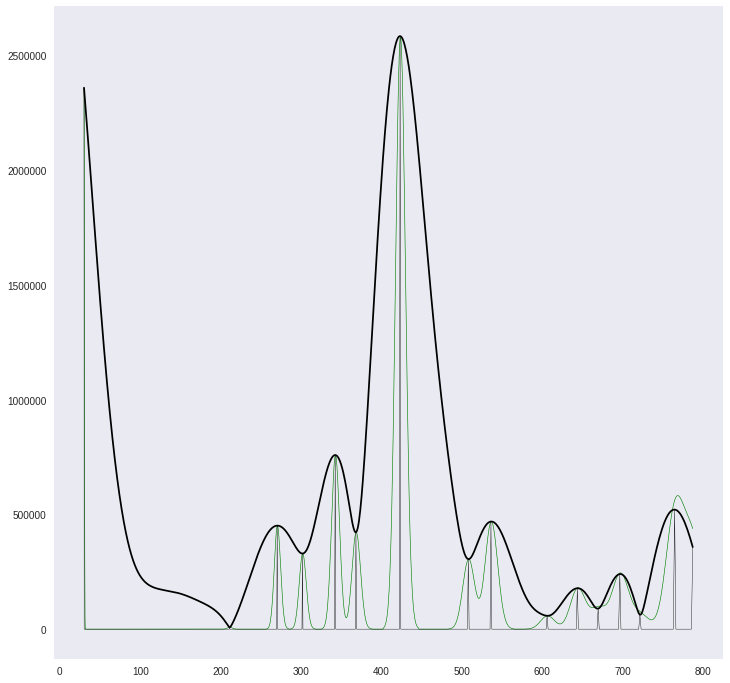

In [86]:



from scipy.signal import gaussian

a = spectrogram[72]


minimas_mask = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimums
maximas_mask = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximums

gg = np.zeros(len(a))
gg[minimas_mask] = a[minimas_mask]
gg[maximas_mask] = a[maximas_mask]


blur_kernel = gaussian(50, std=7)
# 
Q_corr = np.correlate(gg, blur_kernel, mode='same')



plt.plot(f, Q_corr, 'g', linewidth=0.6)




plt.plot(f, a, 'k')
plt.plot(f, gg, 'k', linewidth=0.4)
plt.grid(False)

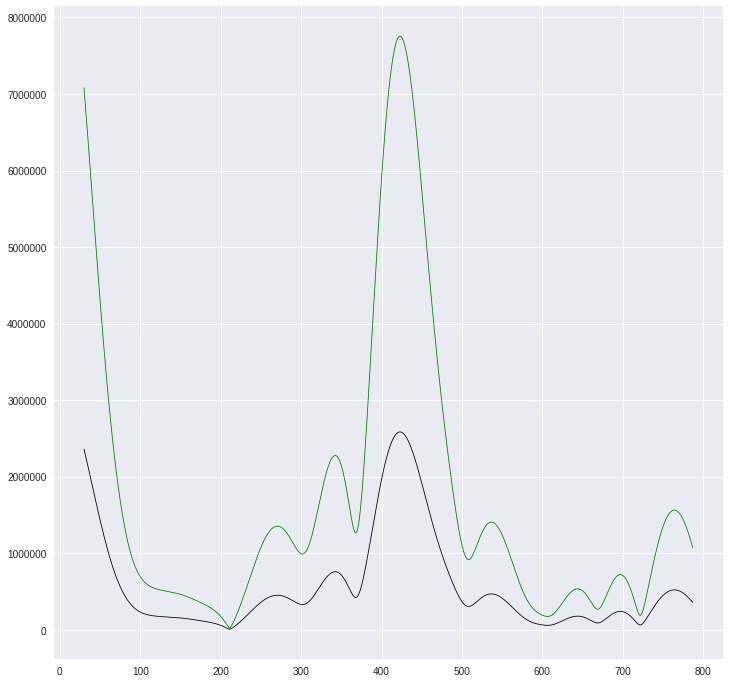

In [82]:
from scipy.signal import unit_impulse
sharp_kernel = unit_impulse(50, 'mid') * 3

# sharp_kernel = gaussian(500, std=1)
# plt.plot(sharp_kernel)

sharp_a = np.correlate(a, sharp_kernel, mode='same')


plt.plot(f, a      , 'k', linewidth=0.8)
plt.plot(f, sharp_a, 'g', linewidth=0.8)